# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.6693],
         [-0.8329]]),
 tensor([[ 1.0000e+00,  6.6930e-01,  2.2398e-01,  4.9971e-02,  8.3614e-03,
           1.1193e-03,  1.2485e-04,  1.1938e-05,  9.9876e-07,  7.4275e-08,
           4.9712e-09,  3.0248e-10,  1.6871e-11,  8.6859e-13,  4.1525e-14,
           1.8528e-15,  7.7507e-17,  3.0515e-18,  1.1347e-19,  3.9970e-21],
         [ 1.0000e+00, -8.3292e-01,  3.4688e-01, -9.6306e-02,  2.0054e-02,
          -3.3406e-03,  4.6375e-04, -5.5180e-05,  5.7451e-06, -5.3169e-07,
           4.4285e-08, -3.3533e-09,  2.3275e-10, -1.4912e-11,  8.8720e-13,
          -4.9264e-14,  2.5646e-15, -1.2565e-16,  5.8143e-18, -2.5489e-19]]),
 tensor([5.3708, 2.2624]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.0125914  1.220831  -3.4141173  5.547841 ]]


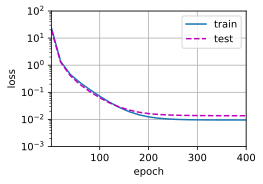

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.4755528 4.046715 ]]


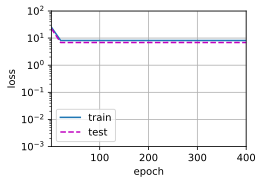

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.01003885e+00  1.29390717e+00 -3.40761590e+00  5.12098598e+00
  -5.42627349e-02  1.29955316e+00  1.94708899e-01  2.18216404e-01
   3.39455134e-03 -4.73892353e-02 -1.04092583e-01 -5.42021394e-02
  -1.28569722e-01  2.07704753e-01  1.79829955e-01 -7.98266008e-03
   1.36406735e-01 -1.10480644e-01  4.25368287e-02 -1.03880882e-01]]


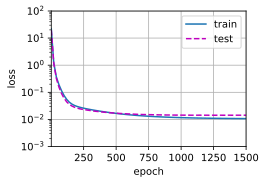

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)